In [10]:
import tensorflow as tf
import numpy as np, pandas as pd
import csv
import matplotlib.pyplot as plt
from utils import plot_series, plot_series_2, trend, seasonal_pattern
from utils import seasonality, noise, generate_synthetic_timeseries
from utils import windowed_dataset, model_forecast

### <font color='brown'> **1) Sunspot series analysis - DNN** </font>
-------------------------------

#### <font color='magenta'> **1.1) Reading the Data** </font>

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


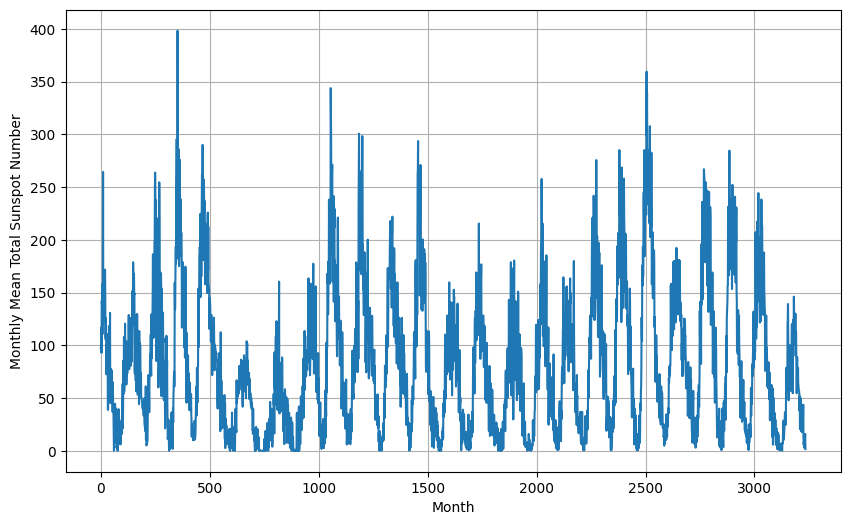

In [13]:
# Initialize lists
time_step = []
sunspots = []

df = pd.read_csv(r"./Data/Sunspots.csv")
display(df.head())

# Open CSV file
with open('./Data/Sunspots.csv') as csvfile:  
  reader = csv.reader(csvfile, delimiter=',')       # Initialize reader  
  next(reader)                                      # Skip the first line  
  for row in reader:        # Append row and sunspot number to lists
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series_2(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

#### <font color='magenta'> **1.2) Splitting the Dataset** </font>

In [14]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### <font color='magenta'> **1.3) Prepare features and labels** </font>


We can then prepare the dataset windows. 

The window size is set to 30 points (equal to 2.5 years).

In [15]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### <font color='magenta'> **1.4) Building the Model** </font>

In [16]:
# We are building the 3-layer dense network
#
# Build the Model
# ---------------
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


#### <font color='magenta'> **1.5) Tuning the Learning Rate** </font>

In [17]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 12s 18ms/step - loss: 61.3620 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 7ms/step - loss: 60.6687 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 6ms/step - loss: 59.8850 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 6ms/step - loss: 59.0045 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 6ms/step - loss: 58.0169 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 6ms/step - loss: 56.9140 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 5ms/step - loss: 55.6897 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 6ms/step - loss: 54.3407 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 6ms/step - loss: 52.8640 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 6ms/step - loss: 51.2498 - lr: 2.8184e-08
Epoch 11/100
93/9

(1e-08, 0.001, 0.0, 100.0)

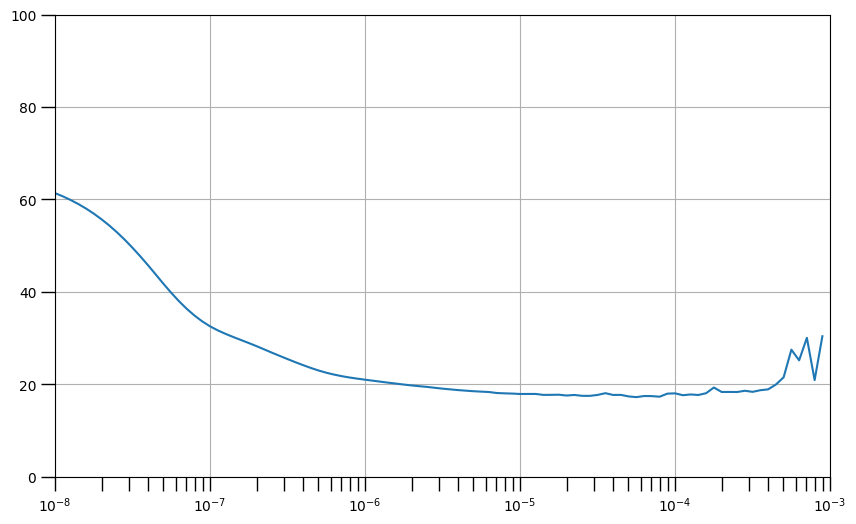

In [18]:
# Plotting the Learning Rates
# ---------------------------

lrs = 1e-8 * (10 ** (np.arange(100) / 20))      # Define the learning rate array
plt.figure(figsize=(10, 6))                     # Set the figure size
plt.grid(True)                                  # Set the grid
plt.semilogx(lrs, history.history["loss"])      # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')       # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 100])                  # Set the plot boundaries

#### <font color='magenta'> **1.6) Training the Model** </font>

In [19]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 8ms/step - loss: 38.4069 - mae: 38.9012
Epoch 2/100
93/93 [==============================] - 1s 6ms/step - loss: 19.8346 - mae: 20.3256
Epoch 3/100
93/93 [==============================] - 1s 6ms/step - loss: 19.2060 - mae: 19.6989
Epoch 4/100
93/93 [==============================] - 1s 7ms/step - loss: 18.6909 - mae: 19.1825
Epoch 5/100
93/93 [==============================] - 1s 7ms/step - loss: 18.5067 - mae: 18.9984
Epoch 6/100
93/93 [==============================] - 1s 6ms/step - loss: 18.3830 - mae: 18.8747
Epoch 7/100
93/93 [==============================] - 1s 7ms/step - loss: 18.0752 - mae: 18.5666
Epoch 8/100
93/93 [==============================] - 1s 6ms/step - loss: 17.7865 - mae: 18.2786
Epoch 9/100
93/93 [==============================] - 1s 6ms/step - loss: 18.2055 - mae: 18.6965
Epoch 10/100
93/93 [==============================] - 1s 6ms/step - loss: 17.8017 - mae: 18.2946
Epoch 11/100
93/93 [===================

#### <font color='magenta'> **1.7) Predicting using the Model** </font>

      1/Unknown - 0s 35ms/step

8/8 [==============================] - 0s 13ms/step


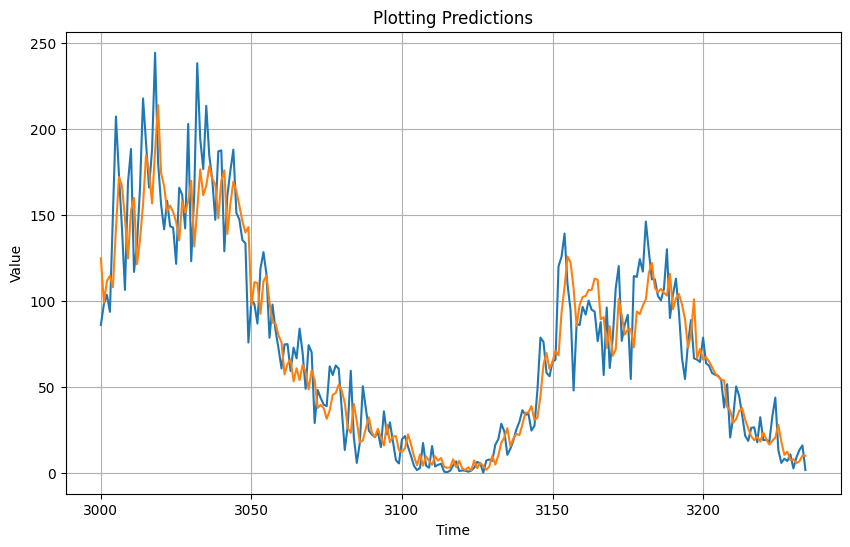

MAE:  14.765128


In [21]:
# Forecasting
# -----------
forecast_series = series[split_time-window_size:-1]         # Reduce the original series
# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()                                # Drop single dimensional axis

plot_series(time_valid, (x_valid, results), title="Plotting Predictions")               # Plot the results

print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())           # Compute the MAE

----------------------------------------------------------------------
-----------------------------------

### <font color='brown'> **2) Sunspot series analysis - DNN + RNN (LSTM) + CNN** </font>
-------------------------------

Here we will try one more configuration and that is a combination of all these types of networks: 
- the data windows will pass through a convolution
- followed by stacked LSTMs
- followed by stacked dense layers.
    
-------------------------------

#### <font color='magenta'> **2.1) Reading the Data** </font>

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


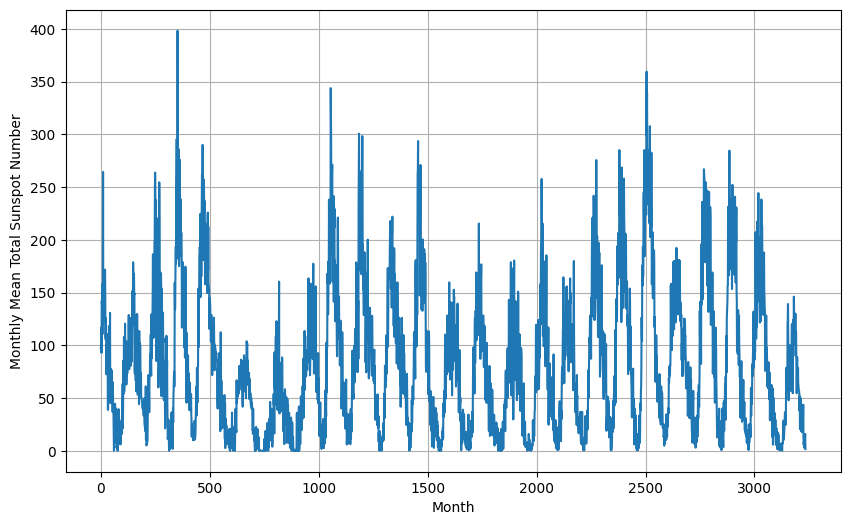

In [22]:
# Initialize lists
time_step = []
sunspots = []

df = pd.read_csv(r"./Data/Sunspots.csv")
display(df.head())

# Open CSV file
with open('./Data/Sunspots.csv') as csvfile:  
  reader = csv.reader(csvfile, delimiter=',')       # Initialize reader  
  next(reader)                                      # Skip the first line  
  for row in reader:        # Append row and sunspot number to lists
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series_2(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

#### <font color='magenta'> **2.2) Splitting the Dataset** </font>

In [23]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### <font color='magenta'> **2.3) Prepare features and labels** </font>


We can then prepare the dataset windows. 

The window size is set to 30 points (equal to 2.5 years).

In [24]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### <font color='magenta'> **2.4) Building the Model** </font>

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

#### <font color='magenta'> **2.5) Tuning the Learning Rate** </font>

In [25]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 1s 7ms/step - loss: 16.2311 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2296 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2283 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 7ms/step - loss: 16.2268 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2253 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2238 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2220 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 5ms/step - loss: 16.2205 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 5ms/step - loss: 16.2188 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 5ms/step - loss: 16.2175 - lr: 2.8184e-08
Epoch 11/100
93/93 

(1e-08, 0.001, 0.0, 100.0)

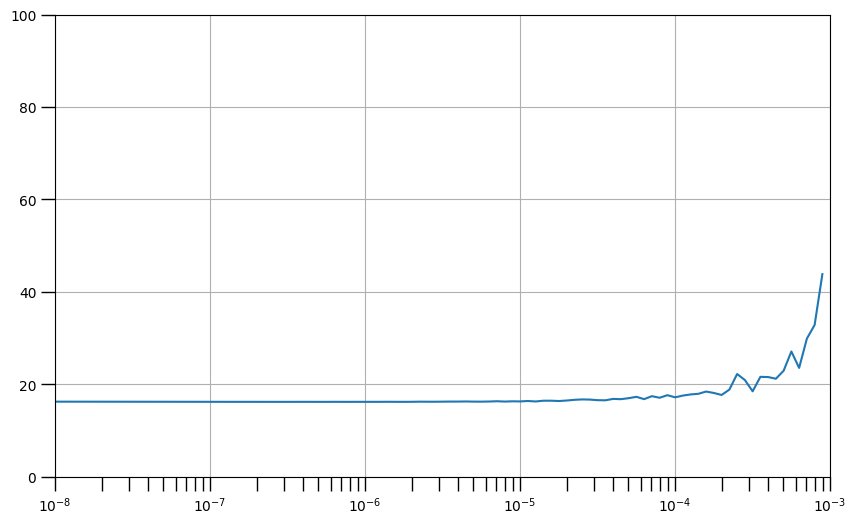

In [26]:
# Plotting the Learning Rates
# ---------------------------

lrs = 1e-8 * (10 ** (np.arange(100) / 20))      # Define the learning rate array
plt.figure(figsize=(10, 6))                     # Set the figure size
plt.grid(True)                                  # Set the grid
plt.semilogx(lrs, history.history["loss"])      # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')       # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 100])                  # Set the plot boundaries

#### <font color='magenta'> **2.6) Training the Model** </font>

In [27]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 7ms/step - loss: 16.2335 - mae: 16.7244
Epoch 2/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2149 - mae: 16.7056
Epoch 3/100
93/93 [==============================] - 1s 5ms/step - loss: 16.2038 - mae: 16.6938
Epoch 4/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2059 - mae: 16.6953
Epoch 5/100
93/93 [==============================] - 1s 7ms/step - loss: 16.1930 - mae: 16.6823
Epoch 6/100
93/93 [==============================] - 1s 6ms/step - loss: 16.2033 - mae: 16.6926
Epoch 7/100
93/93 [==============================] - 1s 6ms/step - loss: 16.1993 - mae: 16.6887
Epoch 8/100
93/93 [==============================] - 1s 6ms/step - loss: 16.1983 - mae: 16.6880
Epoch 9/100
93/93 [==============================] - 1s 6ms/step - loss: 16.1912 - mae: 16.6810
Epoch 10/100
93/93 [==============================] - 1s 5ms/step - loss: 16.1878 - mae: 16.6770
Epoch 11/100
93/93 [===================


#### <font color='magenta'> **2.7) Visualizing the Training Results** </font>

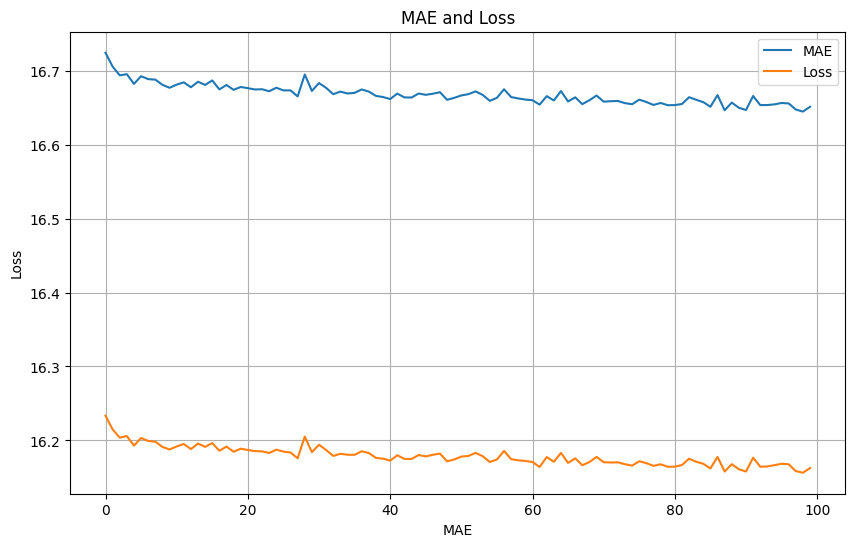

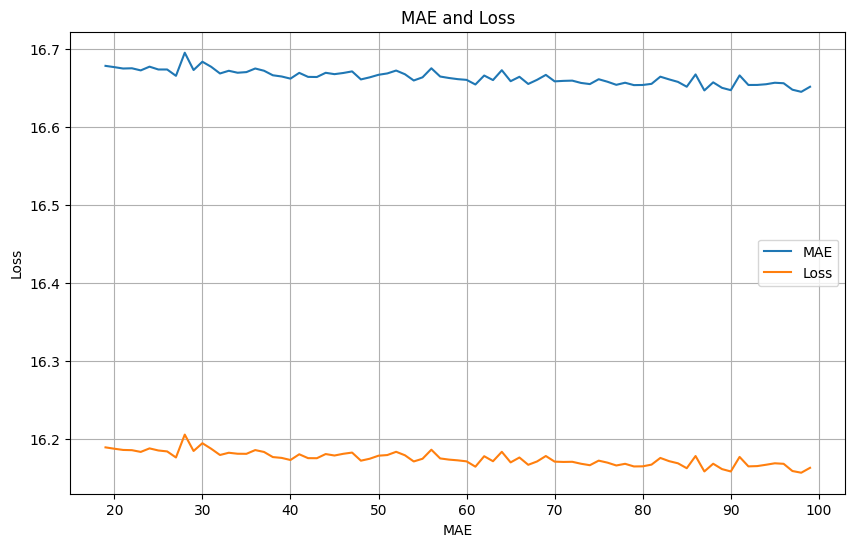

In [28]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series_2(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series_2(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

#### <font color='magenta'> **2.8) Predicting the Model** </font>

8/8 [==============================] - 0s 15ms/step


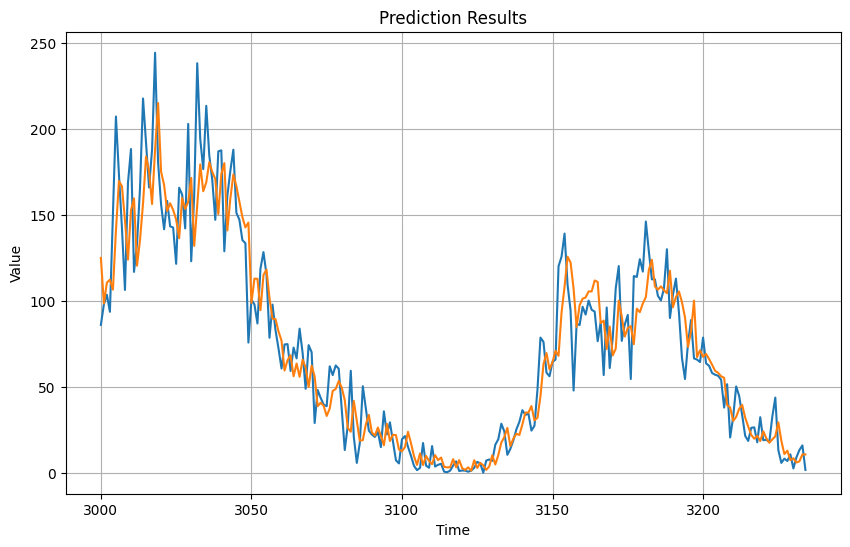

MAE:  14.745246


In [29]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()                                                # Drop single dimensional axis
plot_series(time_valid, (x_valid, results), title='Prediction Results')     # Plot the results
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

#### <font color='magenta'> **2.9) Dynamically setting the Learning Rate** </font>

Here we will look at another way to dynamically set the learning rate. 

Since, training for a long time generates less and less changes to the loss and metrics.

In [30]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 [==============================] - 1s 8ms/step - loss: 16.1515 - mae: 16.6402
Epoch 2/10
93/93 [==============================] - 1s 6ms/step - loss: 16.1498 - mae: 16.6382
Epoch 3/10
93/93 [==============================] - 1s 6ms/step - loss: 16.1497 - mae: 16.6381
Epoch 4/10
93/93 [==============================] - 1s 6ms/step - loss: 16.1486 - mae: 16.6371
Epoch 5/10
93/93 [==============================] - 1s 7ms/step - loss: 16.1501 - mae: 16.6384
Epoch 6/10
93/93 [==============================] - 1s 5ms/step - loss: 16.1502 - mae: 16.6388
Epoch 7/10
93/93 [==============================] - 1s 6ms/step - loss: 16.1501 - mae: 16.6384
Epoch 8/10
93/93 [==============================] - 1s 6ms/step - loss: 16.1491 - mae: 16.6377
Epoch 9/10
93/93 [==============================] - 1s 6ms/step - loss: 16.1483 - mae: 16.6368
Epoch 10/10
93/93 [==============================] - 1s 6ms/step - loss: 16.1486 - mae: 16.6372


-----------------------------------------

- At some point, the static learning rate we set might no longer be the optimal one when the model has been learning for some time. 
- We may want to decrease it some more to see better improvements. 

> - One way to do that is to have the training loop gradually decay the learning rate per epoch. 
> - We can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). 

This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

-----------------------------------------


In [31]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 [==============================] - 1s 7ms/step - loss: 16.1496 - mae: 16.6382
Epoch 2/40
93/93 [==============================] - 1s 6ms/step - loss: 16.1502 - mae: 16.6390
Epoch 3/40
93/93 [==============================] - 1s 7ms/step - loss: 16.1513 - mae: 16.6401
Epoch 4/40
93/93 [==============================] - 1s 6ms/step - loss: 16.1480 - mae: 16.6363
Epoch 5/40
93/93 [==============================] - 1s 6ms/step - loss: 16.1487 - mae: 16.6371
Epoch 6/40
93/93 [==============================] - 1s 5ms/step - loss: 16.1484 - mae: 16.6370
Epoch 7/40
93/93 [==============================] - 1s 5ms/step - loss: 16.1486 - mae: 16.6371
Epoch 8/40
93/93 [==============================] - 1s 6ms/step - loss: 16.1482 - mae: 16.6367
Epoch 9/40
93/93 [==============================] - 1s 6ms/step - loss: 16.1479 - mae: 16.6362
Epoch 10/40
93/93 [==============================] - 1s 6ms/step - loss: 16.1481 - mae: 16.6367
Epoch 11/40
93/93 [==============================

      1/Unknown - 0s 31ms/step

8/8 [==============================] - 0s 12ms/step


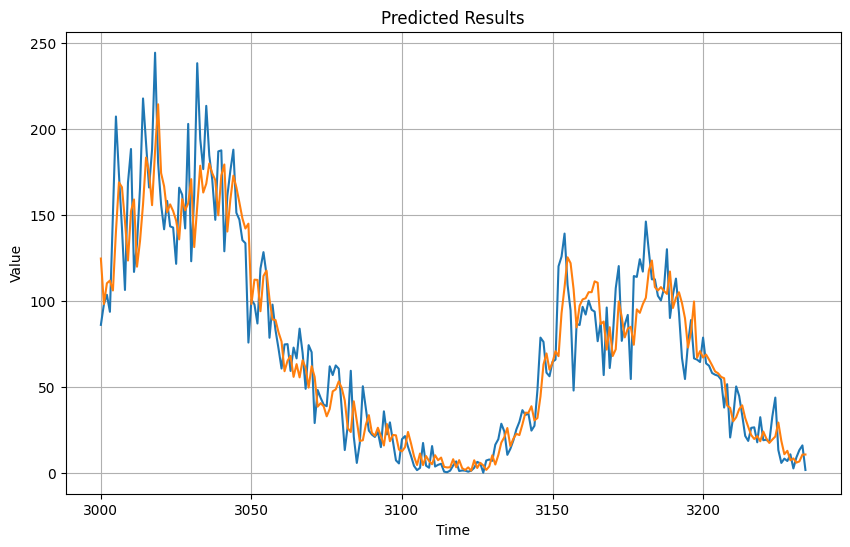

MAE:  14.7421255


In [33]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), title="Predicted Results")


# Compute the MAE
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

---------------------------
---------------------------
---------------------------